--- STEP 0: PERSIAPAN DATA ---
Berhasil memuat blok 8x8 dari tengah './img/1.jpeg'.
Blok RGB 8x8 asli:
[[189 189 190 192 194 194 192 191]
 [190 190 191 190 191 192 194 194]
 [191 189 188 188 189 191 194 196]
 [187 183 183 186 189 189 192 195]
 [183 179 180 186 190 189 189 193]
 [185 182 183 188 190 190 192 194]
 [191 189 188 189 190 190 194 195]
 [192 194 193 191 190 192 194 194]]

========================= PROSES ENCODING =========================

--- STEP 1: Konversi RGB ke YCbCr ---
Blok Y (Luminance):
[[170 170 172 174 176 176 174 173]
 [172 172 173 172 173 174 176 176]
 [173 171 170 170 171 173 176 178]
 [169 165 165 168 171 171 174 177]
 [165 161 162 168 172 171 171 175]
 [167 164 165 170 172 172 172 174]
 [173 171 170 171 172 172 174 175]
 [174 176 175 173 172 174 176 176]]

--- STEP 2: Chroma Subsampling ---
Untuk demo ini pada satu blok 8x8, kita menggunakan subsampling 4:4:4 (tidak ada subsampling).
Artinya, blok Cb dan Cr memiliki resolusi penuh (8x8).
Pada JPEG nyata, subs

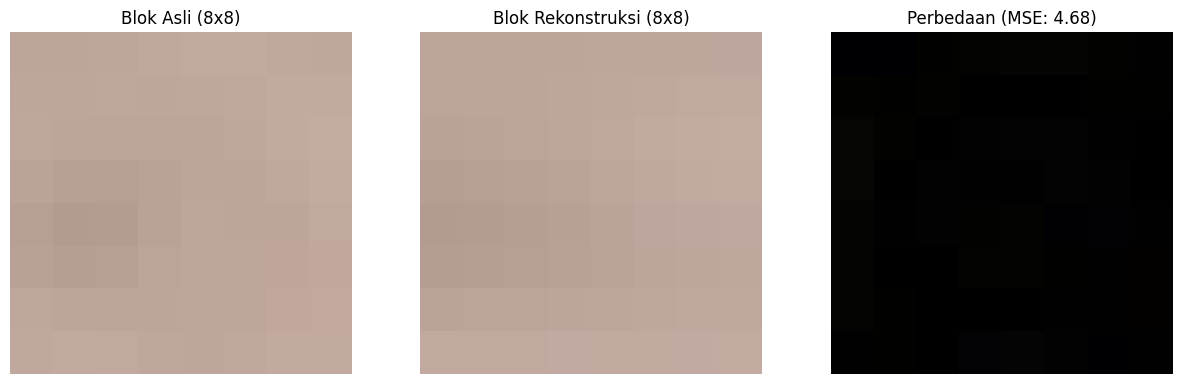

In [11]:
import numpy as np
import scipy.fftpack
from PIL import Image
import matplotlib.pyplot as plt

# ==============================================================================
# Inisialisasi dan Fungsi Bantuan
# ==============================================================================

# Tabel Kuantisasi Standar JPEG (Luminance dan Chrominance)
# Tabel ini digunakan untuk mengurangi informasi pada frekuensi tinggi
Q_LUM = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

Q_CHROM = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

# Urutan pemindaian Zigzag untuk mengubah matriks 8x8 menjadi array 1D
# Ini membantu mengelompokkan koefisien frekuensi rendah bersama
ZIGZAG_ORDER = np.array([
    [0, 1, 5, 6, 14, 15, 27, 28],
    [2, 4, 7, 13, 16, 26, 29, 42],
    [3, 8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 61],
    [21, 34, 37, 47, 50, 56, 62, 63],
    [35, 36, 48, 49, 57, 58, 59, 60]
])

# Fungsi untuk menerapkan 2D DCT
def dct2(block):
    return scipy.fftpack.dct(scipy.fftpack.dct(block.T, norm='ortho').T, norm='ortho')

# Fungsi untuk menerapkan 2D Inverse DCT
def idct2(block):
    return scipy.fftpack.idct(scipy.fftpack.idct(block.T, norm='ortho').T, norm='ortho')

# Fungsi untuk mengubah matriks ke urutan zigzag
def zigzag_scan(matrix):
    vector = np.zeros(64)
    for r in range(8):
        for c in range(8):
            vector[ZIGZAG_ORDER[r, c]] = matrix[r, c]
    return vector

# Fungsi untuk mengembalikan vektor zigzag ke matriks
def inverse_zigzag_scan(vector):
    matrix = np.zeros((8, 8))
    for r in range(8):
        for c in range(8):
            matrix[r, c] = vector[ZIGZAG_ORDER[r, c]]
    return matrix
    
# Fungsi untuk Run-Length Encoding (RLE) sederhana
def run_length_encode(vector):
    encoded = []
    count = 0
    # Mulai dari elemen kedua karena elemen pertama (DC) ditangani secara terpisah
    for value in vector[1:]:
        if value == 0:
            count += 1
        else:
            encoded.append((count, value))
            count = 0
    # Tandai akhir blok dengan (0,0)
    encoded.append((0, 0))
    # Tambahkan koefisien DC di awal
    return [vector[0]] + encoded

# Fungsi untuk dekode Run-Length Encoding (RLE)
def run_length_decode(encoded_vector):
    dc_coefficient = encoded_vector[0]
    decoded = [dc_coefficient]
    for pair in encoded_vector[1:]:
        zeros, value = pair
        decoded.extend([0] * zeros)
        if (zeros, value) != (0, 0): # Jangan tambahkan nilai jika itu adalah penanda EOB
             decoded.append(value)
    # Pastikan panjangnya 64
    while len(decoded) < 64:
        decoded.append(0)
    return np.array(decoded[:64])


# ==============================================================================
# STEP 0: PERSIAPAN DATA
# ==============================================================================
# Menggunakan makroblok 8x8 dari gambar './img/1.jpeg'.
# Jika file tidak ditemukan, sebuah blok sampel akan dibuat sebagai fallback.

print("--- STEP 0: PERSIAPAN DATA ---")
try:
    # Membaca gambar
    img = Image.open('./img/1.jpeg').convert('RGB')
    img_array = np.array(img)
    h, w, _ = img_array.shape
    
    # Menghitung posisi awal untuk mengambil blok 8x8 dari tengah
    start_row = (h - 8) // 2
    start_col = (w - 8) // 2
    
    # Mengambil blok 8x8 dari tengah gambar
    original_rgb_block = img_array[start_row:start_row + 8, start_col:start_col + 8, :]
    print("Berhasil memuat blok 8x8 dari tengah './img/1.jpeg'.")
except FileNotFoundError:
    print("File './img/1.jpeg' tidak ditemukan. Menggunakan blok sampel sebagai gantinya.")
    # Membuat blok sampel dengan gradien warna jika file tidak ada
    original_rgb_block = np.zeros((8, 8, 3), dtype=np.uint8)
    for i in range(8):
        for j in range(8):
            original_rgb_block[i, j, 0] = (i * 32) % 256  # Gradien Merah
            original_rgb_block[i, j, 1] = (j * 32) % 256  # Gradien Hijau
            original_rgb_block[i, j, 2] = 128             # Biru konstan

print("Blok RGB 8x8 asli:")
print(original_rgb_block[:, :, 0]) # Tampilkan channel Merah saja untuk keringkasan


# ==============================================================================
# PROSES ENCODING
# ==============================================================================


# ==============================================================================
# PROSES ENCODING
# ==============================================================================
print("\n" + "="*25 + " PROSES ENCODING " + "="*25)

# --- STEP 1: Seleksi Makroblok dan Konversi Ruang Warna (RGB ke YCbCr) ---
print("\n--- STEP 1: Konversi RGB ke YCbCr ---")
# Matriks konversi standar
T = np.array([[0.299, 0.587, 0.114],
              [-0.168736, -0.331264, 0.5],
              [0.5, -0.418688, -0.081312]])

ycbcr_block = np.zeros_like(original_rgb_block, dtype=np.float64)
for i in range(8):
    for j in range(8):
        rgb = original_rgb_block[i, j, :]
        ycbcr = np.dot(T, rgb)
        ycbcr_block[i, j, :] = ycbcr

Y = ycbcr_block[:,:,0]
Cb = ycbcr_block[:,:,1] + 128 # Cb dan Cr di-offset ke [0, 255]
Cr = ycbcr_block[:,:,2] + 128 # sebelum level shifting

print("Blok Y (Luminance):")
print(Y.astype(int))


# --- STEP 2: Chroma Subsampling ---
print("\n--- STEP 2: Chroma Subsampling ---")
print("Untuk demo ini pada satu blok 8x8, kita menggunakan subsampling 4:4:4 (tidak ada subsampling).")
print("Artinya, blok Cb dan Cr memiliki resolusi penuh (8x8).")
print("Pada JPEG nyata, subsampling (misal 4:2:0) akan mengambil rata-rata blok piksel 2x2 pada Cb dan Cr untuk mengurangi data.")


# --- STEP 3: Level Shifting & Transformasi DCT ---
print("\n--- STEP 3: Level Shifting & DCT ---")
# Geser rentang nilai dari [0, 255] ke [-128, 127]
Y_shifted = Y - 128
Cb_shifted = Cb - 128
Cr_shifted = Cr - 128

# Terapkan DCT pada setiap blok
Y_dct = dct2(Y_shifted)
Cb_dct = dct2(Cb_shifted)
Cr_dct = dct2(Cr_shifted)

print("Matriks DCT untuk blok Y (setelah level shifting):")
print(np.round(Y_dct, 2))


# --- STEP 4: Kuantisasi ---
print("\n--- STEP 4: Kuantisasi ---")
# Bagi setiap koefisien DCT dengan nilai dari tabel kuantisasi
Y_quantized = np.round(Y_dct / Q_LUM).astype(int)
Cb_quantized = np.round(Cb_dct / Q_CHROM).astype(int)
Cr_quantized = np.round(Cr_dct / Q_CHROM).astype(int)

print("Matriks Y terkuantisasi (banyak nilai menjadi nol):")
print(Y_quantized)


# --- STEP 5: Zigzag Scan & RLE ---
print("\n--- STEP 5: Zigzag Scan & RLE ---")
# Ubah matriks 2D menjadi vektor 1D dengan urutan zigzag
Y_zigzag = zigzag_scan(Y_quantized)
Cb_zigzag = zigzag_scan(Cb_quantized)
Cr_zigzag = zigzag_scan(Cr_quantized)

print("Hasil Zigzag Scan pada blok Y:", Y_zigzag.astype(int))

# Terapkan Run-Length Encoding pada data zigzag
# (Hanya Y yang ditampilkan sebagai contoh)
Y_rle = run_length_encode(Y_zigzag)
print("\nHasil RLE pada blok Y:")
print("DC:", Y_rle[0], "AC:", Y_rle[1:])


# --- STEP 6: Generasi Bitstream (Huffman Coding) ---
print("\n--- STEP 6: Generasi Bitstream (Huffman Coding) ---")
print("Ini adalah langkah terakhir dalam encoding.")
print("Data RLE (seperti yang ditunjukkan di atas) akan dikompresi lebih lanjut menggunakan Huffman Coding.")
print("Setiap pasangan (jumlah nol, nilai) dan koefisien DC akan diganti dengan kode biner yang panjangnya bervariasi.")
print("Proses ini menghasilkan bitstream akhir yang merupakan file JPEG yang sebenarnya.")
print("Untuk penyederhanaan, implementasi Huffman tidak disertakan di sini.")


# ==============================================================================
# PROSES DECODING
# ==============================================================================
print("\n" + "="*25 + " PROSES DECODING " + "="*25)

# --- STEP 1: Parsing Bitstream & Decode RLE ---
print("\n--- STEP 1: Parsing Bitstream & Decode RLE ---")
print("Kita mulai dari data RLE yang kita hasilkan sebelumnya (melewatkan dekompresi Huffman).")
# Dekode RLE untuk mendapatkan kembali vektor zigzag
# (Hanya Y yang ditampilkan sebagai contoh)
Y_zigzag_decoded = run_length_decode(Y_rle)

print("Vektor Zigzag hasil dekode RLE (untuk blok Y):")
print(Y_zigzag_decoded.astype(int))


# --- STEP 2: Inverse Zigzag Scan ---
print("\n--- STEP 2: Inverse Zigzag Scan ---")
# Ubah kembali vektor 1D menjadi matriks 8x8
Y_quantized_reconstructed = inverse_zigzag_scan(Y_zigzag_decoded)
# Lakukan hal yang sama untuk Cb dan Cr (disimulasikan karena kita tidak membuat RLEnya)
Cb_quantized_reconstructed = inverse_zigzag_scan(Cb_zigzag)
Cr_quantized_reconstructed = inverse_zigzag_scan(Cr_zigzag)


print("Matriks terkuantisasi hasil Inverse Zigzag (blok Y):")
print(Y_quantized_reconstructed.astype(int))


# --- STEP 3: D-Kuantisasi (De-quantization) ---
print("\n--- STEP 3: De-kuantisasi ---")
# Kalikan kembali dengan tabel kuantisasi untuk mengembalikan skala koefisien DCT
Y_dct_reconstructed = Y_quantized_reconstructed * Q_LUM
Cb_dct_reconstructed = Cb_quantized_reconstructed * Q_CHROM
Cr_dct_reconstructed = Cr_quantized_reconstructed * Q_CHROM

print("Matriks DCT hasil de-kuantisasi (blok Y):")
print(np.round(Y_dct_reconstructed, 2))


# --- STEP 4: Inverse DCT (IDCT) ---
print("\n--- STEP 4: Inverse DCT ---")
# Terapkan IDCT untuk mengubah data dari domain frekuensi kembali ke domain spasial
Y_reconstructed_shifted = idct2(Y_dct_reconstructed)
Cb_reconstructed_shifted = idct2(Cb_dct_reconstructed)
Cr_reconstructed_shifted = idct2(Cr_dct_reconstructed)

print("Blok Y setelah IDCT (masih dalam rentang -128 hingga 127):")
print(np.round(Y_reconstructed_shifted, 2))


# --- STEP 5: Upsampling & Konversi YCbCr ke RGB ---
print("\n--- STEP 5: Upsampling & Konversi YCbCr ke RGB ---")
# Geser kembali rentang nilai dari [-128, 127] ke [0, 255]
Y_reconstructed = Y_reconstructed_shifted + 128
Cb_reconstructed = Cb_reconstructed_shifted + 128
Cr_reconstructed = Cr_reconstructed_shifted + 128

print("Upsampling: Karena kita menggunakan 4:4:4, tidak ada upsampling yang diperlukan.")

# Gabungkan kembali blok Y, Cb, Cr
ycbcr_reconstructed = np.stack([Y_reconstructed, Cb_reconstructed - 128, Cr_reconstructed - 128], axis=-1)

# Matriks konversi invers dari YCbCr ke RGB
T_inv = np.linalg.inv(T)
reconstructed_rgb_block = np.zeros_like(original_rgb_block, dtype=np.float64)

for i in range(8):
    for j in range(8):
        reconstructed_rgb_block[i,j,:] = np.dot(T_inv, ycbcr_reconstructed[i,j,:])

# Klip nilai ke rentang [0, 255] yang valid dan konversi ke integer
reconstructed_rgb_block = np.clip(reconstructed_rgb_block, 0, 255).astype(np.uint8)

print("\nBlok RGB 8x8 hasil rekonstruksi (channel Merah):")
print(reconstructed_rgb_block[:, :, 0])


# ==============================================================================
# PERBANDINGAN
# ==============================================================================
print("\n" + "="*28 + " HASIL AKHIR " + "="*28)

print("\nBlok RGB Asli (Channel Merah):")
print(original_rgb_block[:, :, 0])

print("\nBlok RGB Rekonstruksi (Channel Merah):")
print(reconstructed_rgb_block[:, :, 0])

# Hitung Mean Squared Error (MSE) untuk melihat tingkat error
mse = np.mean((original_rgb_block.astype(np.float64) - reconstructed_rgb_block.astype(np.float64)) ** 2)
print(f"\nMean Squared Error (MSE) antara blok asli dan rekonstruksi: {mse:.2f}")
print("Nilai MSE yang lebih besar dari 0 menunjukkan bahwa kompresi bersifat 'lossy' (ada informasi yang hilang).")


# Visualisasi (opsional, jika Anda menjalankan di lingkungan dengan GUI)
try:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_rgb_block)
    axes[0].set_title("Blok Asli (8x8)")
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed_rgb_block)
    axes[1].set_title("Blok Rekonstruksi (8x8)")
    axes[1].axis('off')

    # Hitung gambar perbedaan (error)
    diff_image = np.abs(original_rgb_block.astype(np.float64) - reconstructed_rgb_block.astype(np.float64)).astype(np.uint8)
    axes[2].imshow(diff_image)
    axes[2].set_title(f"Perbedaan (MSE: {mse:.2f})")
    axes[2].axis('off')
    
    plt.show()
except Exception as e:
    print("\nVisualisasi matplotlib dilewati karena tidak berada di lingkungan GUI.")